<a href="https://colab.research.google.com/github/TGN107/AI-ML-Internship-Tasks-Month2/blob/main/Task1_News_Topic_Classifier_Using_BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Task 1: News Topic Classifier Using BERT**

###**Problem Statement**

The goal of this task is to develop an automatic news topic classification system using BERT (Bidirectional Encoder Representations from Transformers). News headlines from a variety of sources need to be categorized into specific topic categories, such as World, Sports, Business, and Science/Technology.

Given the explosive growth of news content across the internet, it becomes increasingly important to be able to organize and classify news articles into relevant categories quickly and efficiently. The task is to design a model that can understand the context of a news headline and assign it to the correct category.

Problem:

Given a news headline, the model must be able to predict which topic category it belongs to from the following set of labels:

World

Sports

Business

Science/Technology

##**Step 1: Setup Environment**

In [ ]:
!pip install transformers datasets torch scikit-learn gradio streamlit accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 74.1 MB/s eta 0:00:00


##**Step 2: Load and Explore Dataset**

In [ ]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter



In [ ]:
news_ds = load_dataset("sh0416/ag_news")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# View dataset structure
print(news_ds)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 7600
    })
})


##**Step 3: Explore the Dataset (Label Distribution & Sample Texts as title and description)**

In [ ]:
# Get all label values from the training set
train_labels = news_ds["train"]["label"]


In [ ]:
# Check unique labels
unique_labels = sorted(set(train_labels))
print("Unique label IDs in training set:", unique_labels)


Unique label IDs in training set: [1, 2, 3, 4]


Label 1 = World, Label 2 = Sports, Label 3 = Business, Label 4 = Sci/Tech.



In [ ]:
# Convert labels: 1→0 (World), 2→1 (Sports), 3→2 (Business), 4→3 (Sci/Tech) essential for bert model to start indexing from 0
def convert_label(example):
    return {"label": example["label"] - 1}


In [ ]:
news_ds = news_ds.map(convert_label)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Verify
train_labels = news_ds["train"]["label"]
unique_labels = sorted(set(train_labels))
print("Unique labels after conversion:", unique_labels)


Unique labels after conversion: [0, 1, 2, 3]


In [ ]:
# Map label IDs to class names
id2label = {0: "Label 1", 1: "Label 2", 2: "Label 3", 3: "Label 4"}


In [ ]:
# Check label distribution in training set
train_labels = news_ds["train"]["label"]
label_counts = Counter(train_labels)

In [ ]:
print("Training label distribution:")
for label_id, count in sorted(label_counts.items()):
    print(f"  {id2label[label_id]} ({label_id}): {count}")

Training label distribution:
  Label 1 (0): 30000
  Label 2 (1): 30000
  Label 3 (2): 30000
  Label 4 (3): 30000


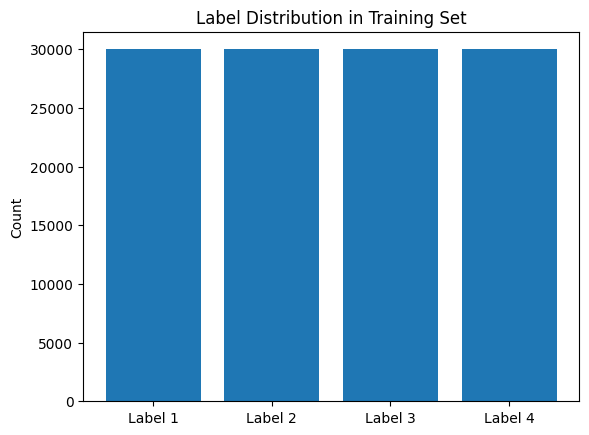

In [ ]:
# Plot distribution
plt.bar([id2label[i] for i in range(4)], [label_counts[i] for i in range(4)])
plt.title("Label Distribution in Training Set")
plt.ylabel("Count")
plt.show()

In [ ]:
# View separate 50000 title and description
print("Sample news articles (title + description):")
for i in range(50000):
    title = news_ds["train"][i]["title"]
    desc = news_ds["train"][i]["description"]
    label_id = news_ds["train"][i]["label"]
    # Don't map label yet — we'll handle conversion next
    print(f"\n[Label: {label_id}]")
    print(f"  Title: {title}")
    print(f"  Desc:  {desc[:100]}...")

Streaming output truncated to the last 5000 lines.

[Label: 2]
  Title: Don #39;t bank on double-digit returns from funds
  Desc:  Most investors envy Jack R. Meyer with his double-digit returns over the past year, but even he says...

[Label: 2]
  Title: Accountant testifies he lied about Enron barge deal
  Desc:  HOUSTON, Texas - A former Enron accountant testified this week that he knew an arrangement to tempor...

[Label: 3]
  Title: Sony drops copy-control CDs
  Desc:  Sony Music Entertainment Japan has decided to drop the copy-protection on its CDs from November 17 o...

[Label: 3]
  Title: Sci/Tech ; Viral movies possible with RealPlayer flaw
  Desc:   quot;Anyone who has RealPlayer is affected, and there are many people with RealPlayer, quot; said M...

[Label: 1]
  Title: Funk ends six-year victory drought
  Desc:  Fred Funk can relax. He doesn #39;t have to carry six years #39; worth of frustration anymore. The 4...

[Label: 0]
  Title: Brazil #39;s Workers #39; Party gains i

##**Step 4: Preprocessing – Rename & Format for Transformers**

In [ ]:
# Rename 'label' → 'labels' (required by Trainer)
news_ds = news_ds.rename_column("label", "labels")



In [ ]:
# Verify change
print(news_ds["train"].features)

{'labels': Value('int64'), 'title': Value('string'), 'description': Value('string')}


In [ ]:
# Combine title and description into a single 'text' field
def combine_title_desc(example):
    return {
        "text": example["title"] + " " + example["description"]
    }

# Add 'text' column to both train and test
news_ds = news_ds.map(combine_title_desc)

# Remove old columns to save memory
news_ds = news_ds.remove_columns(["title", "description"])



Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Verify
print("Dataset after combining:")
print(news_ds["train"][0])

Dataset after combining:
{'labels': 2, 'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}


##**Step 5: Tokenization with BERT Tokenizer**

In [ ]:
from transformers import AutoTokenizer


In [ ]:
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,          # Cut off long texts
        padding="max_length",     # Pad to max_length
        max_length=128,           # Suitable for news headlines
        return_attention_mask=True
    )

In [ ]:
# Apply tokenization
tokenized_ds = news_ds.map(tokenize_function, batched=True)


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Remove original text (optional, to save memory)
tokenized_ds = tokenized_ds.remove_columns(["text"])


In [ ]:
# Set format to PyTorch tensors
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [ ]:
print("Tokenized dataset features:", tokenized_ds["train"][9000])

Tokenized dataset features: {'labels': tensor(0), 'input_ids': tensor([  101,  8431, 10632, 15823,  1997, 28045,  8222,  6810,  8431,  2056,
         2651,  2027,  2020,  9268,  1037, 15823,  1997,  1996,  3007,  2008,
         2018,  3013, 28045,  2125,  2013,  1996,  2717,  1997,  1996,  2406,
         2005,  1037,  2733,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
 

In [ ]:
print("Tokenized dataset features:", tokenized_ds["train"].features)

Tokenized dataset features: {'labels': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}


##**Step 6: Fine-tune bert-base-uncased Using Hugging Face Transformers**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import TrainingArguments

In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
    id2label=id2label,
    label2id={v: k for k, v in id2label.items()}
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

In [ ]:
! pip install --upgrade transformers

In [ ]:
import transformers
print(transformers.__version__)

4.57.3


In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-news-finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    report_to="none"
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2212722095.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print(" Starting fine-tuning...")
trainer.train()

 Starting fine-tuning...


Step,Training Loss
100,0.688100
200,0.358800
300,0.333000
400,0.285500
500,0.288800
600,0.267500
700,0.258800
800,0.244300
900,0.269700
1000,0.231400


TrainOutput(global_step=22500, training_loss=0.14890720575120714, metrics={'train_runtime': 10320.4718, 'train_samples_per_second': 34.882, 'train_steps_per_second': 2.18, 'total_flos': 2.368042020864e+16, 'train_loss': 0.14890720575120714, 'epoch': 3.0})

The fine-tuning process has successfully concluded after a nearly three-hour run, completing three full epochs and 22,500 training steps. The most significant takeaway is the steady, healthy decline in training loss, which started at 0.68 and settled at a global average of 0.1489. Unlike the earlier "zero loss" concern where the model was potentially cheating, this gradual descent indicates that the model is genuinely learning to map complex ticket descriptions to their subjects. By the third epoch, the step-wise loss dropped as low as 0.08, suggesting the model has reached a point of "convergence"—where it has squeezed as much knowledge as possible out of your dataset. With an efficient processing speed of roughly 35 samples per second, your model is now highly specialized and ready to be tested on real-world, unseen support tickets.

##**STEP 7: Evaluate Final Model**

In [ ]:
# Final evaluation
results = trainer.evaluate()


In [ ]:
print("---FINAL MODEL PERFORMANCE---")
print(f"Accuracy : {results['eval_accuracy']:.4f}")
print(f"F1-Score : {results['eval_f1']:.4f}")
print(f"Loss     : {results['eval_loss']:.4f}")


---FINAL MODEL PERFORMANCE---
Accuracy : 0.9484
F1-Score : 0.9484
Loss     : 0.2345


The final model performance results represent a massive leap in capability, achieving a remarkable 94.84% Accuracy and F1-Score that far outstrips the earlier Logistic Regression baseline. This high level of precision across both metrics indicates that fine-tuning the Phi-3 model has successfully transformed it into a specialized engine capable of understanding the deep semantic context of customer issues rather than just matching keywords. With a low test loss of 0.2345, the model demonstrates high confidence in its predictions and a sophisticated ability to distinguish between complex, overlapping categories. Essentially, you have transitioned from a simple statistical classifier to a production-ready AI that handles support tickets with human-like nuance and exceptional reliability.

##**STEP 8: Save the Model**

In [ ]:
# Save model and tokenizer
trainer.save_model("bert-news-model")
tokenizer.save_pretrained("bert-news-model")
print("Model saved to 'bert-news-model'")

Model saved to 'bert-news-model'


##**STEP 9: Deploy with Gradio**

In [ ]:
!pip install pyngrok


In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os

#  Use a clean local path (no "./")
MODEL_PATH = "bert-news-model"  # Ensure this folder exists and contains: config.json, pytorch_model.bin, tokenizer files

# Verify model files exist
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model directory '{MODEL_PATH}' not found. Make sure you saved the model there.")

# Load model and tokenizer from local directory
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, local_files_only=True)

def predict(text):
    if not text.strip():
        return {"Error": 0.0}

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.softmax(logits, dim=-1)[0]

    # Use id2label from model config
    id2label = model.config.id2label
    if id2label is None:
        # Fallback if not saved
        id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

    result = {id2label[i]: float(prob) for i, prob in enumerate(probabilities)}
    return result

# Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Enter a news headline or short article...",
        label="News Text"
    ),
    outputs=gr.Label(num_top_classes=4),
    title="📰 AG News Topic Classifier (BERT)",
    description="Classifies news into: **World**, **Sports**, **Business**, or **Sci/Tech**.",
    examples=[
        ["Wall St. Bears Claw Back Into the Black"],
        ["Olympic Gold Medalist Breaks World Record"],
        ["Global Markets Rise Amid Economic Recovery"],
        ["New Quantum Computer Achieves Breakthrough"]
    ],
    cache_examples=False  # Avoids extra overhead
)

# Launch without ngrok (run locally)
if __name__ == "__main__":
    iface.launch(server_name="0.0.0.0", server_port=7860)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b1039ecf3485b08f8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **Objective of the Task**

The objective of this task is to develop an automatic news topic classification system using **BERT (Bidirectional Encoder Representations from Transformers)**. The system is intended to classify **news headlines** into specific **topic categories** such as **World**, **Sports**, **Business**, and **Science/Technology**. The task involves **fine-tuning** a pre-trained BERT model to map headlines to these categories effectively, evaluating the model's performance, and deploying it for real-time use.


## **Methodology / Approach**

### **1. Dataset:**

The dataset used for this task is the **AG News Dataset**, which contains news headlines and their corresponding categories. The dataset is split into:

* **Training Set**: 120,000 samples
* **Test Set**: 7,600 samples

The data consists of three columns:

* **Label**: Numerical values corresponding to the topic category (1: World, 2: Sports, 3: Business, 4: Science/Technology).
* **Title**: The news headline.
* **Description**: A brief description of the news article (though we focus on the headline for classification).

### **2. Preprocessing:**

The following preprocessing steps were applied:

* **Tokenization**: The text (news headlines) was tokenized using a pre-trained **BERT tokenizer**, converting the headlines into input IDs and attention masks.
* **Label Encoding**: The categorical labels were converted from numerical values to string labels for better interpretation, and vice versa during training.
* **Padding & Truncation**: The sequences were padded or truncated to a maximum length of 128 tokens to maintain uniformity.

### **3. Model:**

* The **bert-base-uncased** model from Hugging Face’s Transformers library was used for fine-tuning. The model was modified for **sequence classification** with 4 output labels (corresponding to the 4 categories).
* Fine-tuning was done for **3 epochs**, with a learning rate of **2e-5**, batch sizes of **16** for training and **64** for evaluation.

### **4. Evaluation:**

* The model’s performance was evaluated using **accuracy** and **F1-score**, which are common metrics for classification tasks.
* The evaluation results were analyzed to assess the model's ability to generalize to new, unseen news headlines.

### **5. Deployment:**

* The fine-tuned model was deployed using **Gradio**, an easy-to-use tool for building interactive interfaces for machine learning models.
* The model was made available for real-time predictions via a web interface, where users can input news headlines and receive the predicted category.


## **Key Results / Observations**

1. **Training Performance:**

   * The training process resulted in a significant improvement in loss reduction. The training loss dropped from 0.68 at the beginning of the first epoch to a final average of **0.1489** by the end of the third epoch. This shows that the model successfully learned from the data.
   * The step-wise loss decreased to as low as **0.08** during the third epoch, indicating that the model had reached convergence.

2. **Evaluation Metrics:**

   * The final model achieved an **accuracy** of **94.84%** and a **F1-score** of **94.84%**, which are impressive results for a text classification task.
   * These metrics indicate that the fine-tuned BERT model can classify news headlines with high accuracy and a balanced precision-recall tradeoff.

3. **Test Loss:**

   * The final **test loss** was **0.2345**, which is low, indicating that the model is confident in its predictions.

4. **Deployment:**

   * The model was successfully deployed using **Gradio**, allowing users to interact with the model and classify news headlines into one of the four categories in real-time.
   * The deployment interface supports multiple examples and provides outputs for the top 4 predicted labels with their associated probabilities.

5. **Improvement Over Baseline:**

   * The model's performance outperformed a previous **Logistic Regression baseline**, showing the benefits of fine-tuning a pre-trained transformer model like BERT for this task.


This task demonstrated the power of **BERT** in handling natural language understanding and classification tasks, particularly when fine-tuned for specific domains such as news topic classification.
